In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from svhn_dataset import SVHN

In [40]:
dataset = SVHN().train.map(SVHN.parse)
for sample in dataset.take(10):
    pass
print(sample['image'].shape)
print(sample.keys())
sizes = np.array([x['image'].shape[0] for x in dataset.as_numpy_iterator()])
print(f'training samples: {len(sizes)}')
print(f'max size: {np.max(sizes)}')
print(f'min size: {np.min(sizes)}')
print(f'mean size: {np.mean(sizes)}')
print(f'number of samples bigger then 128: {np.sum(sizes > 128)}')
print(f'number of samples bigger then 256: {np.sum(sizes > 256)}')

(40, 40, 3)
dict_keys(['bboxes', 'classes', 'image'])
training samples: 10000
max size: 293
min size: 18
mean size: 76.3944
number of samples bigger then 128: 1011
number of samples bigger then 256: 15


In [41]:
input_size = 128


for sample in dataset.take(6406):
    pass

@tf.function
def scale(x):
    return dict(image = x['image'],
                classes = x['classes'],
                bboxes = x['bboxes'])



def draw_image_and_bb(image, bbs):
    print(f'size: {image.shape}')
    plt.imshow(image)
    ax = plt.gca()
    for bb in bbs:
        ymin, xmin, ymax, xmax = bb.numpy()
        y, x = (ymin + ymax) / 2, (xmin + xmax) / 2
        h, w = (ymax - ymin), (xmax - xmin)
        rect = patches.Rectangle((xmin, ymin),w,h,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()
    

print(f'max size: {max_size}')
draw_image_and_bb(sample['image'].numpy(), sample['bboxes'])

NameError: name 'max_size' is not defined

# Dataset properties
max size: 293
mean size: 76.4
number of images bigger than 128: 1011
train size: 10000

In [ ]:
def generate_anchors(pyramid_levels, image_size, first_feature_scale=4, anchor_scale=4.0, aspect_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)], num_scales=3): 
    boxes_all = []
    for s in range(pyramid_levels):
        boxes_level = []
        for octave in range(num_scales):
            for aspect_h, aspect_w in aspect_ratios:
                scale = 2 ** (octave / num_scales)
                stride = first_feature_scale * 2 ** s
                base_anchor_size = anchor_scale * stride * scale
                anchor_size_x = base_anchor_size * aspect_w / 2.0
                anchor_size_y = base_anchor_size * aspect_h / 2.0

                x = np.arange(stride / 2, image_size, stride)
                y = np.arange(stride / 2, image_size, stride)
                xv, yv = np.meshgrid(x, y)
                xv = xv.reshape(-1)
                yv = yv.reshape(-1)

                boxes = np.vstack((yv - anchor_size_y, xv - anchor_size_x,
                    yv + anchor_size_y, xv + anchor_size_x))
                boxes = np.swapaxes(boxes, 0, 1)
                boxes_level.append(np.expand_dims(boxes, axis=1))
        boxes_level = np.concatenate(boxes_level, axis=1)
        boxes_all.append(boxes_level.reshape(-1, 4))
    return np.vstack(boxes_all) 

anchors = generate_anchors(4, 128, anchor_scale=3.0, first_feature_scale =4)

In [ ]:
from importlib import reload
import efficientdet
reload(efficientdet)
net = efficientdet.EfficientDet(5, 9, input_size= 128)

(None, 4, 4, 1280),(None, 8, 8, 112),(None, 16, 16, 40),(None, 32, 32, 24)
(None, 32, 32, 24)


In [ ]:
input_tensor = tf.random.uniform((2, 128, 128, 3), dtype=tf.float32)
output = net(input_tensor)
print(output[0].shape)
print(output[1].shape)

(2, 12240, 5)
(2, 12240, 4)


In [87]:
import train
from importlib import reload
import utils
import efficientdet
import data
reload(data)
reload(train)
from data import create_data, SVHN
args, argstr = train.parse_args(['--test'])
args.test = True
args.batch_size = 1
args.learning_rate = 0.5
args.epochs = 100

num_classes = SVHN.LABELS
pyramid_levels = args.pyramid_levels
smallest_stride = 2**(6 - pyramid_levels)
anchors = utils.generate_anchors(pyramid_levels, args.image_size, 
    first_feature_scale=smallest_stride, anchor_scale=float(smallest_stride),
    num_scales=args.num_scales, aspect_ratios=args.aspect_ratios)

train_dataset, dev_dataset, eval_dataset = create_data(args.batch_size, 
            anchors, image_size = args.image_size,
            test=args.test)

# Prepare network and trainer
anchors_per_level = args.num_scales * len(args.aspect_ratios)
network = efficientdet.EfficientDet(num_classes, anchors_per_level,
            input_size = args.image_size, pyramid_levels = pyramid_levels) 
model = train.RetinaTrainer(network, anchors, train_dataset, (dev_dataset, eval_dataset), args)

# Start training
print(f'running command: {argstr}') 
model.fit()

# Save model
model.save()
print('model saved')


running command: /opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py -f /home/jovyan/.local/share/jupyter/runtime/kernel-76ce5e2a-a99e-4047-9bf2-c742bafbf872.json --test
epoch: 0, loss: 19.1615, val_loss: 18.7099, val_class_loss: 17.9148, val_reg_loss: 0.7951, val_score: 0.0000
epoch: 1, loss: 17.9542, val_loss: 18.4186, val_class_loss: 17.7232, val_reg_loss: 0.6954, val_score: 0.0000
epoch: 2, loss: 14.8556, val_loss: 18.1698, val_class_loss: 17.5159, val_reg_loss: 0.6539, val_score: 0.0000
epoch: 3, loss: 7.8686, val_loss: 18.0130, val_class_loss: 17.3774, val_reg_loss: 0.6356, val_score: 0.0000
epoch: 4, loss: 6.3092, val_loss: 17.8612, val_class_loss: 17.3116, val_reg_loss: 0.5496, val_score: 0.0000
epoch: 5, loss: 10.5441, val_loss: 17.8539, val_class_loss: 17.3182, val_reg_loss: 0.5357, val_score: 0.0000
epoch: 6, loss: 5.9077, val_loss: 17.7449, val_class_loss: 17.2116, val_reg_loss: 0.5332, val_score: 0.0000
epoch: 7, loss: 4.9593, val_loss: 17.6428, val_class_loss: 17.

size: (128, 128, 3)


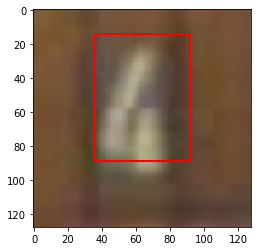

In [75]:
for sample in model.eval_dataset.batch(1).take(1):
    class_pred, bbox_pred = network(sample['image'], training=False)

tf.nn.softmax(class_pred, -1)
draw_image_and_bb(sample['image'][0,...].numpy(), sample['bbox'][0,...])

size: (128, 128, 3)


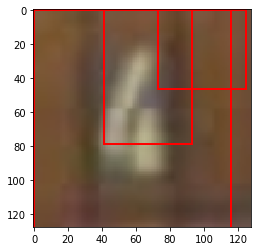

In [88]:
import tensorflow as tf
regression_pred = utils.bbox_from_fast_rcnn(model.anchors, bbox_pred) 
regression_pred = tf.expand_dims(regression_pred, 2)
boxes, scores, classes, valid = tf.image.combined_non_max_suppression(
    regression_pred, tf.nn.softmax(class_pred), 3, 5, score_threshold=0.15,
    iou_threshold=0.4, clip_boxes=False) 
boxes = tf.clip_by_value(boxes, 0, model.args.image_size)
draw_image_and_bb(sample['image'][0,...].numpy(), boxes[0,...])
print(scores)
print(classes)

In [86]:
print(scores)
print(classes)
print(tf.nn.softmax(class_pred))

tf.Tensor([[0.15767111 0.15765233 0.15764466 0.         0.        ]], shape=(1, 5), dtype=float32)
tf.Tensor([[4. 4. 4. 0. 0.]], shape=(1, 5), dtype=float32)
tf.Tensor(
[[[0.0938841  0.09362771 0.0930524  ... 0.09392995 0.09312813 0.09385416]
  [0.09459154 0.09367797 0.0931063  ... 0.09421024 0.09324457 0.09407139]
  [0.0946658  0.0937545  0.0930659  ... 0.09433005 0.09327316 0.09407075]
  ...
  [0.09422625 0.09419849 0.09288642 ... 0.09434143 0.09252257 0.09413584]
  [0.09420831 0.09416851 0.09288946 ... 0.09435248 0.09257793 0.09416331]
  [0.09388688 0.09413322 0.09300867 ... 0.09407331 0.09320948 0.09427426]]], shape=(1, 336, 10), dtype=float32)
